<img   src="../figuras/logos/Logo TalentQ Azul.png" align=right  width="12%"/>
<br>

<table width="100%">
<td style="font-size:40px;font-style:italic;text-align:left;background-color:rgba(0, 220, 170,0.7)">
El arte de medir II
</td></table>



$ \newcommand{\bra}[1]{\langle #1|} $
$ \newcommand{\ket}[1]{|#1\rangle} $
$ \newcommand{\braket}[2]{\langle #1|#2\rangle} $
$ \newcommand{\i}{{\color{blue} i}} $ 
$ \newcommand{\Hil}{{\mathcal H}} $
$ \newcommand{\boldn}{{\bf n}} $
$ \newcommand{\tr}{{\rm tr}}$



In [4]:
import sys
sys.path.append('../')
import macro_tQ as tQ

import numpy as np
import scipy.linalg as la
from IPython.display import display,Markdown,Latex
import matplotlib.pyplot as plt
from qiskit.tools.visualization import array_to_latex

# Medidas de estados multicúbit

Un aparato de medida en la base  asociada al operador hermítico $\sigma_z^{\otimes n} = Z\otimes \ldots \otimes Z$ hace colapsar el estado  que mide a un elemento $\ket{x}$ de la *base computacional*, que identificamos mediante una cadena de bits $a_{n-1}...a_0$ con $a_i=0,1$,  donde $x= a_{n-1}2^{n-1}+...+2^0 a_0$.


<br>

<figure>
<a id='fig_ref'></a>
<img src="images/Multimeter_zbasis.png" align=center width='400px'/>
<center></center>
</figure>


## Circuitos con múltiples cúbits y medidas en Qiskit
<br>



Inicialicemos un estado de 3 cúbits 
$$
\ket{\psi} = \sum_{i,j,k = 0,1} c_{ijk} \ket{ijk} = \sum_a c_a \ket{a}
$$

In [5]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from numpy import linalg as la
from qiskit.quantum_info import Statevector

'''definimos un estado de entrada en H^3$'''
psi =[1.,-2, -2,1,1,0,2,-1]
psi/=la.norm(psi)
#psi = tQ.random_ket(8).reshape(8)


Statevector(psi).draw('Latex')

<IPython.core.display.Latex object>

Las medida es esencialmente un mapa entre n-cúbits cuánticos y n-bits clásicos.

$$
\ket{i_{n-1} i_{n-2}\, ... \, i_0} \in \Hil^{\otimes n}  ~~\to ~~ i_{n-1}i_{n-2}...i_0\in \{0,1\}^n
$$

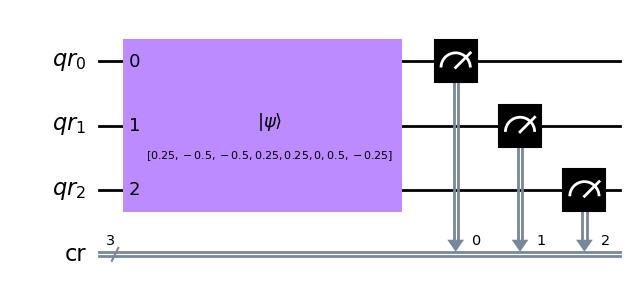

In [6]:
qr = QuantumRegister(3,name='qr')
cr = ClassicalRegister(3,name='cr')

qc = QuantumCircuit(qr,cr)
qc.initialize(psi,qr)


qc.measure(qr,cr)
#qc.measure(qr,reversed(list(cr)))  # esta opcion invierte la asignación de bits clasicos a cúbits
#qc.measure([qr[0],qr[1]],[cr[1],cr[2]])

qc.draw(output='mpl')

La manera de tener acceso a las amplitudes (tomografía del estado) es midiendo repetidas veces para reconstruir la función de probabilidad

Cuentas= {'011': 6286, '111': 6138, '100': 6310, '110': 24908, '001': 25064, '000': 6264, '010': 25030}


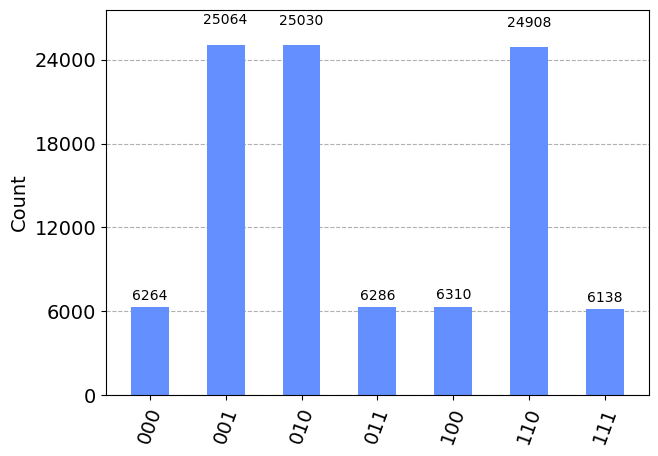

In [7]:
from qiskit import Aer, execute 
'definimos el simulador'
M_simulator = Aer.get_backend('qasm_simulator')
'numero todal de medidas'
nshots = 100000


'ejecutamos el circuito'
job=execute(qc,backend=M_simulator,shots=nshots) 
result=job.result()
counts = result.get_counts()        
print('Cuentas=',counts) #diccionario de cuentas


from qiskit.tools.visualization import plot_histogram
plot_histogram(counts) # Mostramos un histograma de resultados

Ahora podemos generar diccionarios con las probabilidades y la amplitudes de los distintos resultados, para obtener la tomografía del estado 

In [34]:
def probs_amps(cuentas): # frecuencias_dict es un diccionario con la estadística de resultados
    
    prob_dict=cuentas.copy() # vamos a modificar el diccionario "cuentas" con las probabilidades 
    amp_dict=cuentas.copy()  # y las amplitudes
    keys = list(cuentas.keys())
    values = list(cuentas.values())
    
    N=sum(values)
    probabilidades = [v/N for v in values] # lista de frecuencias relativas
 
    for i in range(len(keys)):
        prob_dict[keys[i]]= probabilidades[i]
        amp_dict[keys[i]] = np.sqrt(probabilidades[i]) #las amplitudes, sólo en valor absoluto, las fases no son accesibles
    
    return  prob_dict, amp_dict

probs, amps = probs_amps(counts)

print("Probabilidades =",probs )

print("Amplitudes =", amps )

Probabilidades = {'110': 0.2505, '001': 0.2508, '100': 0.06093, '011': 0.06187, '111': 0.06134, '000': 0.06302, '010': 0.25154}
Amplitudes = {'110': 0.500499750249688, '001': 0.5007993610219565, '100': 0.24684002916869055, '011': 0.24873680869545625, '111': 0.24766913412857888, '000': 0.2510378457523885, '010': 0.5015376356765262}


# Medidas en bases generales

Vamos a suponer que queremos medir en una base ortonormal arbitraria $\{\ket{ x}'\}$, $x=0,...,2^n-1$. 

$\Rightarrow~ $ buscamos un circuito que, a la llegada de un vector  concreto de la base $\ket{x}'=\ket{i_{n-1}...i_0}'$, devuelva exactamente *la  colección* de bits:  $~i_{n-1}...i_0$.

Vamos a suponer que conocemos el operador unitario que relaciona esta base con la  base computacional  

$$\ket{ x}'= U\ket{x}~~~~~~\Longrightarrow ~~~~~~   U^\dagger\ket{x}' = \ket{ x}  \, .$$



Entonces es evidente que sólo tenemos que añadir el operador $U^\dagger$ antes de usar el medidor estándar. 


<br>

<center>
<figure>
<a id='fig_ref'></a>
<img src="images/Multimeter_basis.png" align=center width='50%'/>
<center></center>
</figure>
</center>


## Medidas  de Pauli

En caso más frecuente consiste en medir diferentes cúbits en diferentes bases de Pauli, $X$, $Y$ ó $Z$.

En este caso, $U= R_1\otimes \ldots \otimes R_n$ es un producto de *rotaciones locales*, $Z\to X$ ó $Z\to Y$ 

 Por ejemplo el siguiente circuito mide en la base $Z_0X_1Y_2$

<br>

<center>
<figure>
<a id='fig_ref'></a>
<img src="images/XYZ_multimeter.png" align=center width='25%'/>
<center></center>
</figure>
</center>
<br>

Definamos una función que añade aparatos de medida en bases $X$, $Y$ ó $Z$ a partir de una *cadena* como 'xxy' etc 


In [35]:
def add_multimeasure_XYZ(qc,paulistring):

    assert(qc.num_qubits==len(paulistring)) #check whether width of circuit coincides with length of Pauli string

    for i,basis in enumerate(reversed(paulistring)):
        if  basis == 'X':
            qc.h(i)    
            qc.measure(i, i)
        elif basis == 'Z':
            qc.measure(i, i)
            pass    
        elif basis == 'Y':
            qc.sdg(i)
            qc.h(i)
            qc.measure(i, i)

    return qc 

Veamos un ejemplo

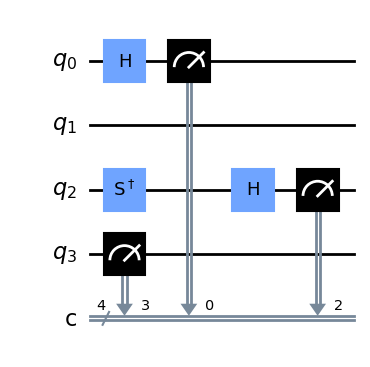

In [36]:
from qiskit import QuantumCircuit
qc = QuantumCircuit(4,4)
add_multimeasure_XYZ(qc,'ZYIX')  # probar a cambiar el aparato de medida
qc.draw('mpl')

## Medida de Bell

El circuito 

<figure>
<a id='fig_ref'></a>
<img src="images/Bell_basis.png" align=center width='200px'/>
<center></center>
</figure>

<br>

 genera la <i>base de Bell</i> $\ket{B_{xy}} = \ket{xy}_B $ a partir de la <i>base computacional</i> $\{\ket{xy}\}$ 
 <br>
<br>

\begin{array}{rcl}
\ket{00}_B &=& \frac{1}{\sqrt{2}} \big( \ket{00} + \ket{11} \big) \\
\ket{01}_B &=& \frac{1}{\sqrt{2}} \big( \ket{01} + \ket{10} \big) \\
\ket{10}_B &=& \frac{1}{\sqrt{2}} \big( \ket{00} - \ket{11} \big) \\
\ket{11}_B &=& \frac{1}{\sqrt{2}} \big( \ket{01} - \ket{10} \big) \\
\end{array}




El circuito que efectúa una **medida de Bell**  

$$
\ket{xy}_B \to xy
$$
utiliza el *desentrelazador* 

$$U^\dagger = ( \hbox{CNOT}\cdot H)^\dagger = H\cdot \hbox{CNOT}$$ 

antes del medidor 

<br>

<center>
<figure>
<a id='fig_ref'></a>
<img src="images/Bell_meter.png" align=center width='40%'/>
<center></center>
</figure>
</center>



Creemos el circuito

In [15]:
def add_Bell_measurement(qc,qubits=[0,1]):
    qc.cx(qubits[0],qubits[1])
    qc.h(0)
    qc.barrier()
    qc.measure([0,1],[1,0])

Ahora verificamos

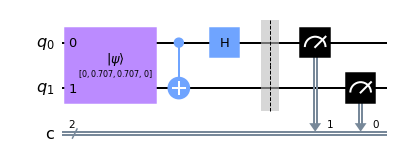

{'01': 1024}

In [18]:
from qiskit import QuantumCircuit

# creamos el circuito
qc = QuantumCircuit(2,2)

# definimos la base de Bell
B00 = np.array([1,0,0,1]/np.sqrt(2))
B01 = np.array([1,0,0,-1]/np.sqrt(2))
B10 = np.array([0,1,1,0]/np.sqrt(2))
B11 = np.array([0,1,-1,0]/np.sqrt(2))

# inicializamos el estado de entrada en cualquiera de los estados anteriores
qc.initialize(B10,[0,1])

# añadimos el medidor en la base de Bell
add_Bell_measurement(qc,[0,1])
display(qc.draw('mpl'))

execute(qc,backend=M_simulator).result().get_counts()

# Valores esperados de observables multi-cúbit

El *problema* esencial para medir un valor esperado $\bra{\psi} A \ket{\psi}$ es que, en general,  $A$ **no es un operador unitario**. Por tanto no se puede incluir como parte de un circuito

Si pudiésemos expresar  como una combinación de operadores unitarios, $A = \sum_i c_i U_i$, entonces sí podríamos calcular cadar valor esperado $\langle U_i\rangle$ mediante un circuito y, finalmente, componer el resultado $\langle A\rangle = \sum_i c_i \langle U_i\rangle$

Una base  la constituyen las *cadenas de Pauli*,  $U = \sigma_{i_1}\otimes \ldots \otimes \sigma_{i_n}$ que nos, a la vez, hermíticas y unitarias, y permiten expandir cualquier operador hermítico

\begin{equation}
A = \sum_{i_1,...,i_n=0}^3 a_{i_1\ldots i_n} \, \sigma_{i_1}\otimes \ldots \otimes \sigma_{i_n}
\end{equation}

donde $\sigma_i = (I,X,Y,Z)$


Por ejemplo, con $n=3$ 
$$
\sigma_2\otimes \sigma_0 \otimes \sigma_3 =  Y\otimes I\otimes Z 
$$

In [51]:
' Matrices de Pauli'
s0 = np.matrix([[1,0],[0,1]]) # matriz identidad
s1 = np.matrix([[0,1],[1,0]])
s2 = np.matrix([[0,-1j],[1j,0]])
s3 = np.matrix([[1,0],[0,-1]])

Pauli_basis = [s0,s1,s2,s3]

' Cadena de Pauli YIZ = s2s0s3' 
Pauli_string_203 = np.kron(s2,np.kron(s0,s3))
array_to_latex(Pauli_string_203)

<IPython.core.display.Latex object>

los coeficientes se pueden obtener calculando las trazas

$$
a_{i_1\ldots i_n} =\frac{1}{2^n} \tr (A \,  \sigma_{i_1}\otimes \ldots  \otimes\sigma_{i_n})
$$


In [50]:
'Matriz arbitraria'
A = np.random.rand(8,8) + 1j* np.random.rand(8,8)

'Proyección'
a_203 = np.trace(np.dot(A,Pauli_string_203))/2**3

print('a_{203} = ', a_203)

a_{203} =  (-0.025107382263148403+0.09576192818349502j)



Por tanto sólo tenemos que averiguar los valores esperados de cadenas de Pauli

$$
\langle A \rangle_{\psi} =  \sum_{i_1,...,i_n=0}^3 a_{i_1\ldots i_n} \langle \sigma_{i_1}\otimes \ldots   \otimes\sigma_{i_n}\rangle
$$

## Valores esperados de cadenas de Pauli

Veamos cómo calcular el valor esperado del operador

$$
\langle Z\otimes Z\otimes Z\rangle_\Psi  = \bra{\Psi}   Z\otimes Z\otimes Z \ket{\Psi}
$$

en el siguiente estado

$$
|\psi> = \frac{i}{4}|000>+\frac{1}{\sqrt{8}}|001>+\frac{1+i}{4}|010>+\frac{1+2i}{\sqrt{8}}|101>+\frac{1}{4}|110>
$$


Primero lo inicializamos

In [41]:
' estado '
psi =np.array([1.,-2*1J, -2,1,1J,0,2,-1])
psi/=tQ.norm(psi)

#e_init = tq_random_ket(8).reshape(8)

Statevector(psi).draw('latex')

<IPython.core.display.Latex object>

Dado que $Z\ket{i} = (-1)^i\ket{i}$ donde $i=0,1$, entonces tendremos que, sobre un estado $\ket{i_2 i_1 i_0}$ de la base computacional

$$
Z\otimes Z\otimes Z \ket{i_2 i_1 i_0} = Z\ket{i_2}\otimes Z\ket{i_1}\otimes Z\ket{i_0} = (-1)^{i_2+i_1+i_0}\ket{i_2 i_1 i_0}
$$


entonces el valor esperado  de este operador es

\begin{eqnarray}
\langle Z\otimes Z\otimes Z\rangle_\Psi &=&
\bra{\Psi} Z\otimes Z\otimes Z \ket{\Psi} \\ 
&=& \sum_{i_2,i_1,i_0=0,1}\bra{\Psi} Z\otimes Z\otimes Z \ket{i_2 i_1 i_0}\braket{i_2 i_1 i_0}{\Psi}  \rule{0mm}{10mm}  \\
&=& \sum_{i_2,i_1,i_0=0,1}(-1)^{i_2 + i_1 + i_0}\big|\bra{i_2 i_1 i_0}\Psi\rangle\big|^2 \\ \rule{0mm}{8mm}
&=& \sum_{i_2,i_1,i_0=0,1} (-1)^{i_2 + i_1 + i_0} p(i_2,i_1,i_0) \nonumber\\ 
\end{eqnarray}

El circuito que calcula las probabilidades necesarias es el siguiente

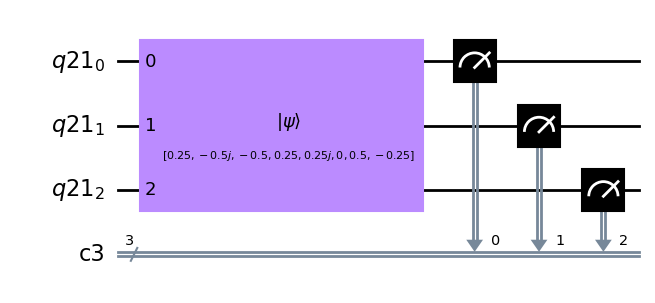

In [42]:
qr = QuantumRegister(3)
cr = ClassicalRegister(3)
qc = QuantumCircuit(qr,cr)

from qiskit.extensions import Initialize

qc.initialize(psi, qr)
qc.measure(qr,cr)
qc.draw(output='mpl')

Ejecutamos el circuito un número de veces y obtenemos el diccionario de cuentas

In [43]:
M_backend = Aer.get_backend('qasm_simulator')
shots=100000

counts = execute(qc,M_backend,shots=shots).result().get_counts()
print(counts)

#from qiskit.tools.visualization import plot_histogram
#plot_histogram(counts)

{'011': 6187, '111': 6239, '001': 25262, '100': 6157, '110': 25085, '000': 6208, '010': 24862}


Finamente $\langle ZZZ\rangle $ es el valor medio  de una distribución de probabilidad de la forma $\{\lambda(x),p(x)\},$ con $x=(i_2 i_1 i_0)$ y

$$
\lambda(x) = (-1)^{i_{2}+i_1+i_0}~~~~~~,~~~~~~ p(x)= \frac{n(x)}{\sum_x n(x)} = \frac{\hbox{counts}(x)}{\hbox{shots}}
$$

La media será el valor esperado que buscamos
$$
 \langle ZZZ\rangle = \bar \lambda = \sum_x \lambda(x) p(x) = \sum_{x}(-1)^{i_{2}+i_1+i_0}\frac{\hbox{counts}(x)}{\hbox{shots}}
$$

In [45]:
mean = 0
for bitstring,count  in counts.items():
    mean += (-1)**(sum([int(bit) for bit in bitstring])) * count/nshots 

print('<ZZZ> =', np.round(mean,5) )

<ZZZ> = -0.2504


Check with the analytic expression $\bra{\psi} ZZZ\ket{\psi} $

In [46]:
Z = np.array([[1,0],[0,-1]])
ZZZ = np.kron(Z,np.kron(Z,Z))
tQ.braket(psi,np.dot(ZZZ,psi))

(-0.25+0j)

También podemos obtener la varianza
$$
\sigma^2 = \sum_{x}\left((-1)^{i_{2}+i_1+i_0}-\bar\lambda \right)^2 p(x)
$$

In [47]:
variance=0
for bitstring,count  in counts.items():
    variance += ((-1)**(sum([int(bit) for bit in bitstring]))-mean)**2 * count/nshots 
    
print('sigma = ', np.sqrt(variance) )

sigma =  0.9681424688546619


Igualmente podemos ver cómo medir el valor esperado

$$
\langle Z\otimes X\otimes Y\rangle_\Psi  = \bra{\Psi}   Z\otimes X\otimes Y \ket{\Psi}
$$

en el mismo estado



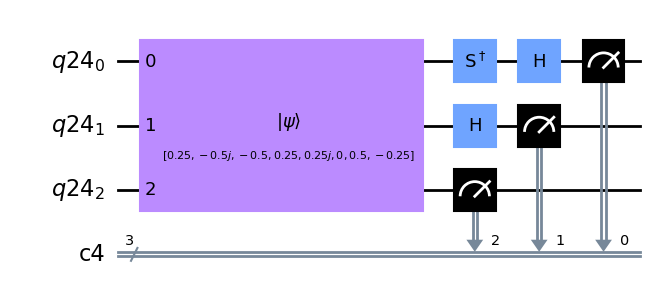

In [48]:
qr = QuantumRegister(3)
cr = ClassicalRegister(3)
qc = QuantumCircuit(qr,cr)

from qiskit.extensions import Initialize

qc.initialize(psi, qr)
add_multimeasure_XYZ(qc,'ZXY')
qc.draw(output='mpl')

In [49]:
counts = execute(qc,M_backend,shots=shots).result().get_counts()
print(counts)

mean = 0
for bitstring,count  in counts.items():
    mean += (-1)**(sum([int(bit) for bit in bitstring])) * count/nshots 

print('<ZXY> =', np.round(mean,5) )

{'101': 6287, '011': 40563, '111': 12534, '001': 3113, '100': 12539, '110': 6067, '010': 3086, '000': 15811}
<ZXY> = 0.37456


<div class='alert alert-block alert-success'>
    <b>Ejercicio </b> 
<br>
escribe una función $expval\_pauli(P,u)$ que reciba como dato, un estado $\ket{u}\in \Hil^{\otimes n}$ y una cadena $P = 'IXYZZ...'$ que represente un operador de Pauli múltiple,  y  devuelva el valor esperado $\bra{u}P\ket{u}$.
    
</div>

<div class="alert alert-block alert-success">
 <b>Ejercicio</b>  
    
escribe una función $expect\_value$ que reciba como argumento un estado $\ket{\psi}$ y un observable $A$, definidos  sobre $\Hil^{\otimes n}$ y devuelva el valor esperado $\bra{\psi}A\ket{\psi}$. Tendrás que generar todas las cadenas de Pauli de longitud $n$. 
<div>


<div class="alert alert-block alert-success">
 <b>Ejercicio</b>  
    
considera el hamiltoniano $H=\lambda (X X+Y Y+Z Z)$ siendo $\lambda =1.47\cdot 10^{-6}eV$. 
 Calcular el valor esperado de la energía $E = \langle H\rangle_\Psi$  en los cuatro estados de Bell
$\ket{\Psi} = \ket{B_{ij}}$. 
<div>


## Medida de Hadamard

Al final, el valor esperado de un operador es un simple número que se obtiene a partir de una distribución aleatoria de valores. 

¿No podríamos diseñar una variable aleatoria cuyo valor medio coincida con ese resultado? 

La medida de Hadamard hace precisamente esto aprovechando el entrelazamiento 



Consideremos el siguiente circuito
<br>
<figure>
<a id='fig_ref'></a>
<img src="images/Hadamard_measure.png" align=center width='280px'/>
<center></center>
</figure>
<br>


El aparato de medida sólo registra valores $\{0,1\}$ como resultado de las medidas proyectivas sobre $\ket{\pm}$

Supongamos que medimos con el aparato $x$. El promedio 

$$
p_{0}-p_{1} = \frac{n_{0}}{N} - \frac{n_{1}}{N} = \langle X\rangle_{ancilla}
$$

es el valor esperado de $X$ en la ancilla. 


Análogamente, será $\langle Y\rangle_{ancilla}$  si usamos el aparato $y$. 

Vamos a demostrar el siguiente resultado que relaciona este número con el valor esperado de $U$ en el estado $\ket{\psi}$


<div class="alert alert-block alert-info",text-align:center>
<p style="text-align: left ;color: navy;">  
<b>Teorema:</b>
<br>
$$
\langle X\rangle_{ancilla} = {\rm Re} \langle U\rangle_{\psi} ~~~,~~~ \langle Y\rangle_{ancilla} = {\rm Im} \langle U\rangle_{\psi}\, 
$$
</div>
<br>


**Demostración**: para el caso $x$, el circuito anterior será
<br>

<figure>
<a id='fig_ref'></a>
<img src="images/Hadamard_measurea.png" align=center width='280px'/>
<center></center>
</figure>

<br>


Un cálculo explícito nos da el estado que llega al aparato de medida
<br>

$$
\ket{0}\ket{\psi} ~\to ~ \ket{\Psi} = \frac{1}{2} \left[\rule{0mm}{3mm} |0\rangle \otimes (1 + U) |\psi\rangle +  |1\rangle \otimes (1 - U) |\psi\rangle \right] \label{hadam}
$$


Si medimos el cúbit ancilla, obtendremos como resultados $\{0,1\}$ con probabilidades 

\begin{eqnarray} 
 p_{0}  &=&  \left\vert \frac{1}{2}  (1 + U) \ket{\psi}  \right\vert^{2} = 
 \frac{1}{4}\bra{\psi}(1 + U^\dagger) (1 + U) \ket{\psi} =\frac{1}{2}(1+\operatorname{Re}\langle \psi|U|\psi\rangle) \nonumber\\
 p_{1}  &=&  \left\vert \frac{1}{2}  (1 - U) \ket{\psi}  \right\vert^{2}=
 \frac{1}{4}\bra{\psi}(1 - U^\dagger) (1 - U) \ket{\psi} =
 \frac{1}{2}(1-\operatorname{Re}\langle \psi|U|\psi\rangle) \nonumber
\end{eqnarray}


El número $ p_{0} - p_{1}$ es el valor esperado de $\langle X\rangle $ en el estado de la ancilla justo  antes de la barrera. Encontramos el siguiente resultado 
$$
\langle{X}\rangle_{ancilla}  =  \hbox{Re}\bra{\psi} U \ket{\psi}
$$


Supongamos ahora que medimos en la base $Y$, es decir, con el circuito siguiente

<br>
<figure>
<a id='fig_ref'></a>
<img src="images/Hadamard_measureb.png" align=center width='400px'/>
<center></center>
</figure>
<br>


<div class="alert alert-block alert-success">
<b>Ejercicio 1.2.2.3</b>
    
    
verificar que la parte imaginaria viene de medir  $\langle Y\rangle$ en la ancilla

$$
\langle{Y}\rangle_{ancilla}  =  \hbox{Im}\bra{\psi} U \ket{\psi} \, .
$$
</div>

<div class="alert alert-block alert-success">
    <b>Ejercicio 1.2.2.4</b> 
    
Obtener el valor esperado de $\langle Z\otimes Z\otimes Z\rangle_\Psi$ en el estado 

$$
|\psi> = \frac{i}{4}|000>+\frac{1}{\sqrt{8}}|001>+\frac{1+i}{4}|010>+\frac{1+2i}{\sqrt{8}}|101>+\frac{1}{4}|110>
$$

usando el método de Hadamard.
</div>

Generamos el circuito de medida de Hadamard

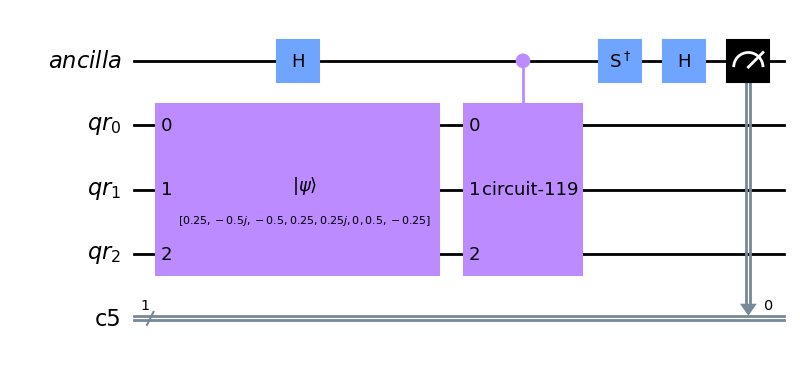

In [52]:
from qiskit import QuantumRegister, QuantumCircuit, ClassicalRegister

qr = QuantumRegister(3, name = 'qr')
qra = QuantumRegister(1, name = 'ancilla')
cr = ClassicalRegister(1)

'creamos el operador como una puerta "gate" que admite el método "control'
qc0 = QuantumCircuit(qr)
qc0.z(qr)
CZZZ_gate = qc0.to_gate().control(1,ctrl_state= 1) 

'creamos el circuito con el operador controlado'
qc_Had = QuantumCircuit(qra,qr,cr)
qc_Had.initialize(psi,qr)
qc_Had.h(qra)  
qc_Had.append(CZZZ_gate,qra[:] + qr[:])
qc_Had.sdg(qra)
qc_Had.h(qra)
qc_Had.measure(qra,cr)

qc_Had.draw('mpl')

Ejecutamos y obtenemos el valor esperado

{'1': 499993, '0': 500007}


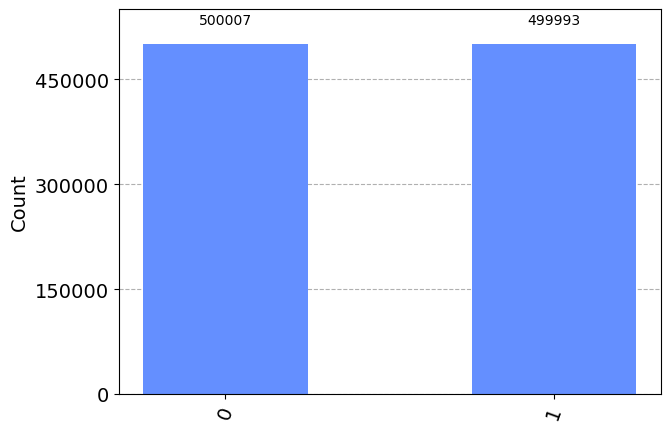

In [54]:
M_backend = Aer.get_backend('qasm_simulator')
shots=1000000

cuentas_Had= execute(qc_Had,M_backend,shots=shots).result().get_counts()
print(cuentas_Had)

from qiskit.tools.visualization import plot_histogram
plot_histogram(cuentas_Had)

In [ ]:
val_esp_sigma(cuentas_Had)

<div class="alert alert-block alert-success">
    <b>Ejercicio 1.2.2.5</b> 
    
define una función <i>add_Hadamadard_measure</i> que reciba un circuito y una  cadena de Pauli y añada al circuito el medidor de Hadamard asociado.
</div>

### Proyección de Hadamard

Supongamos el operador $U$ es un operador sobre 1 cúbit *a la vez hermítico y unitario*.

Por tanto puede ser considerado, a la vez,

- un observable con autovalores reales  $\lambda = \pm1$ y 

- una puerta cuántica con autovalores de módulo unidad



Ello deja a $\lambda = \pm 1$ como los únicos autovalores posibles para un operador así. 
Los operadores $X,Y,Z$ y $H$ son ejemplos de ello. 





Denominemos $\ket{a}_U, \, a=0,1$  los autovectores de $U$ con autovalores $(-1)^a$, es decir $U\ket{a}_U = (-1)^a\ket{a}_U$. 


En este caso, los factores $(1\pm U)$ que aparecen en la medida de Hadamard son proyectores ortogonales sobre los autoestados de $U$



<br>
<figure>
<a id='fig_ref'></a>
<img src="images/HadamardProjection.png" align=center width='280px'/>
<center></center>
</figure>
<br>


La imagen bajo este circuito de un estado de entrada $\ket{0}\ket{\psi}$ ahora será
<br>
<br>

$$
\ket{0}\ket{\psi} = \ket{0}\otimes (\alpha\ket{0}_U + \beta\ket{1}_U) ~~\longrightarrow ~~  \alpha\ket{0}\ket{0}_U +  \beta\ket{1}\ket{1}_U\, .
$$
<br>

Al igual que con los estados de Bell, cada resultado de  medida en la ancilla está correlacionado con un autoestado del operador $U$. 


